# Rozpoznawanie gestów z akcelerometru – CNN-LSTM

In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sprawdzenie dostępności GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Urządzenie treningowe: {device}')


Urządzenie treningowe: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_ADXL345.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [5]:
# 4. Parametry i lista gestów
DATA_FOLDER = '/content/data'
GESTURES = [
    "przesuniecie_w_prawo", "przesuniecie_w_lewo",
    "przesuniecie_w_gore", "przesuniecie_w_dol",
    "okrag_zgodnie_z_ruchem_wskazowek", "okrag_przeciwnie_do_ruchu_wskazowek",
    "litera_Z", "litera_V"
]
SEQUENCE_LENGTH = 50
OVERLAP_RATIO = 0.5
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50


In [6]:
# 5. Przygotowanie Dataset
class GestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.FloatTensor(sequences)
        self.y = torch.LongTensor(labels)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [7]:
# 6. Definicja modelu CNN-LSTM
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels=3, hidden_size=64, n_classes=len(GESTURES)):
        super().__init__()
        # CNN
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(64)
        self.pool  = nn.MaxPool1d(2)
        # LSTM
        self.lstm  = nn.LSTM(64, hidden_size, batch_first=True, dropout=0.2)
        # FC
        self.fc1   = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2   = nn.Linear(32, n_classes)
        self.relu  = nn.ReLU()
    def forward(self, x):
        # x: (batch, seq_len, features) -> (batch, features, seq_len)
        x = x.transpose(1,2)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # (batch, features, seq) -> (batch, seq, features)
        x = x.transpose(1,2)
        # LSTM
        out, _ = self.lstm(x)
        last = out[:,-1,:]                  # ostatni krok
        x = self.relu(self.fc1(last))
        x = self.dropout(x)
        return self.fc2(x)


In [8]:
# 7. Funkcja ładowania i tworzenia sekwencji
def load_sequences(folder):
    scaler = StandardScaler()
    seqs, labs = [], []
    for idx, label in enumerate(GESTURES):
        files = [f for f in os.listdir(folder) if f.startswith(label) and f.endswith('.csv')]
        for fn in files:
            df = pd.read_csv(os.path.join(folder, fn))
            arr = df[['acc_x','acc_y','acc_z']].values
            if len(arr) < SEQUENCE_LENGTH: continue
            arr = scaler.fit_transform(arr)
            step = int(SEQUENCE_LENGTH * (1 - OVERLAP_RATIO))
            for start in range(0, len(arr)-SEQUENCE_LENGTH+1, step):
                seqs.append(arr[start:start+SEQUENCE_LENGTH])
                labs.append(idx)
    print(f'Utworzono {len(seqs)} sekwencji, rozkład gestów: {Counter(labs)}')
    return np.array(seqs), np.array(labs)

# Załaduj dane
X, y = load_sequences(DATA_FOLDER)


Utworzono 11390 sekwencji, rozkład gestów: Counter({2: 1432, 3: 1429, 4: 1428, 6: 1427, 0: 1424, 5: 1423, 7: 1421, 1: 1406})


In [9]:
# 8. Podział na zbiory i DataLoadery
dataset = GestureDataset(X, y)
n_train = int(0.8 * len(dataset))
n_val   = len(dataset) - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')


Train: 9112, Val: 2278


In [10]:
# 9. Inicjalizacja modelu, optymalizatora, funkcji straty
model = CNN_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [11]:
# 10. Pętla trenowania i walidacji
best_acc = 0
history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, EPOCHS+1):
    # trening
    model.train()
    tloss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    # walidacja
    model.eval()
    vloss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
            _, mx = preds.max(1)
            correct += (mx==yb).sum().item()
            total   += yb.size(0)
    # wyniki
    train_loss = tloss/len(train_loader)
    val_loss   = vloss/len(val_loader)
    val_acc    = correct/total*100
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'E{epoch:02d}/{EPOCHS}  TrainLoss:{train_loss:.4f}  ValLoss:{val_loss:.4f}  ValAcc:{val_acc:.2f}%')


E01/50  TrainLoss:1.5142  ValLoss:0.9967  ValAcc:67.65%
E02/50  TrainLoss:0.9793  ValLoss:0.7417  ValAcc:74.28%
E03/50  TrainLoss:0.8351  ValLoss:0.6505  ValAcc:78.31%
E04/50  TrainLoss:0.7462  ValLoss:0.6011  ValAcc:80.07%
E05/50  TrainLoss:0.6857  ValLoss:0.5757  ValAcc:80.55%
E06/50  TrainLoss:0.6453  ValLoss:0.5482  ValAcc:81.39%
E07/50  TrainLoss:0.6309  ValLoss:0.5279  ValAcc:82.44%
E08/50  TrainLoss:0.5889  ValLoss:0.5012  ValAcc:83.06%
E09/50  TrainLoss:0.5680  ValLoss:0.5320  ValAcc:81.52%
E10/50  TrainLoss:0.5429  ValLoss:0.4920  ValAcc:83.45%
E11/50  TrainLoss:0.5390  ValLoss:0.5067  ValAcc:82.35%
E12/50  TrainLoss:0.5168  ValLoss:0.4982  ValAcc:83.10%
E13/50  TrainLoss:0.5009  ValLoss:0.4790  ValAcc:83.41%
E14/50  TrainLoss:0.4886  ValLoss:0.4642  ValAcc:84.06%
E15/50  TrainLoss:0.4809  ValLoss:0.4912  ValAcc:83.80%
E16/50  TrainLoss:0.4644  ValLoss:0.4842  ValAcc:83.41%
E17/50  TrainLoss:0.4496  ValLoss:0.4674  ValAcc:84.20%
E18/50  TrainLoss:0.4389  ValLoss:0.4427  ValAcc

In [12]:
# 11. Wczytanie najlepszego modelu i raport
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb).cpu()
        all_preds += out.argmax(1).tolist()
        all_trues += yb.tolist()
print(classification_report(all_trues, all_preds, target_names=GESTURES))


                                     precision    recall  f1-score   support

               przesuniecie_w_prawo       0.84      0.86      0.85       284
                przesuniecie_w_lewo       0.88      0.86      0.87       292
                przesuniecie_w_gore       0.96      0.96      0.96       266
                 przesuniecie_w_dol       0.91      0.95      0.93       280
   okrag_zgodnie_z_ruchem_wskazowek       0.84      0.80      0.82       307
okrag_przeciwnie_do_ruchu_wskazowek       0.84      0.82      0.83       279
                           litera_Z       0.92      0.88      0.90       306
                           litera_V       0.85      0.93      0.89       264

                           accuracy                           0.88      2278
                          macro avg       0.88      0.88      0.88      2278
                       weighted avg       0.88      0.88      0.88      2278



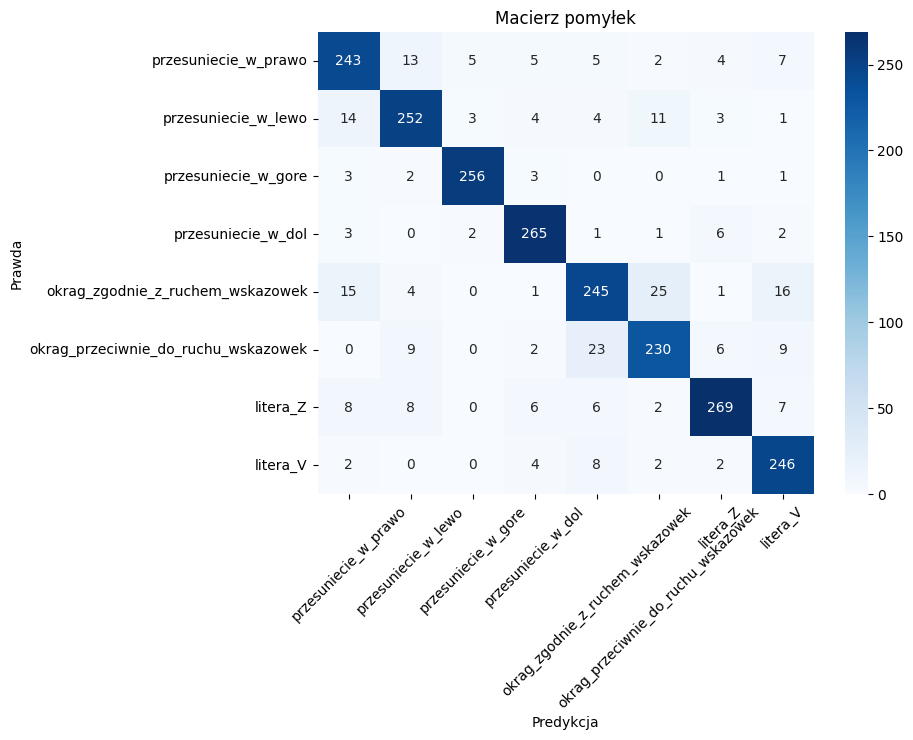

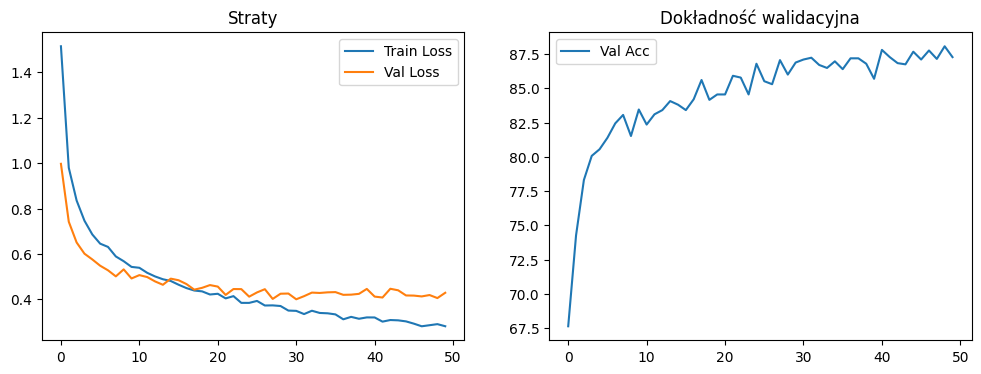

In [13]:
# 12. Wizualizacja: macierz pomyłek i historia trenowania
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GESTURES, yticklabels=GESTURES, cmap='Blues')
plt.xlabel('Predykcja'); plt.ylabel('Prawda'); plt.title('Macierz pomyłek')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.legend(); plt.title('Straty')
plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Dokładność walidacyjna')
plt.show()


Podsumowanie metryk
Model osiągnął ogólną dokładność (accuracy) na poziomie 88% przy 2 278 próbkach walidacyjnych. Średnie makro i ważone miary (precision, recall, f1-score) także wynoszą 0,88, co wskazuje na zrównoważone wyniki między klasami.

Wyniki sugerują, że najtrudniejsze do rozróżnienia są gesty okrągłe oraz przesunięcia w prawo/lewo, prawdopodobnie ze względu na podobny przebieg sygnału akcelerometru.

Możliwe przyczyny słabszych wyników
Niewystarczająca liczba różnorodnych próbek
– Gesty okrągłe mogą przyjmować wiele wariacji (szybkość, promień, płaszczyzna).

Podobieństwo sygnałów
– Przesunięcie w prawo vs w lewo generują symetryczne wzorce.

Parametry przetwarzania sekwencji
– Długość okna (50 próbek) i stopień nakładania (50%) mogą nie optymalnie odcinać początek i koniec gestu.

Hypertuning modelu
– Architektura i zestaw parametrów (liczba filtrów, rozmiary warstw LSTM) niekoniecznie są idealne dla wszystkich gestów.